## Imports

In [99]:
from collections import namedtuple, defaultdict
import matplotlib.pyplot as plt
import numpy as np


Result = namedtuple("result", ["partisans", "asymptotic", "non_partisans_mean"])

In [64]:
PARTISAN_BIAS = 0.3
TRUE_BIAS = 0.6

## Load data

In [217]:
import json
results: list[Result] = []

with open("../output/bigexperiment-1.log", 'r') as f:
    for line in f:
        results.append(Result(**json.loads(line)))

results.sort(key=lambda x: x.partisans)


## Experimentation

In [31]:
results[0]._fields

('partisans', 'asymptotic', 'non_partisans_mean')

In [32]:
results_d = {r.partisans: r for r in results}

In [129]:
result = results_d[0.01]

In [36]:
len(result.asymptotic), len(result.non_partisans_mean), len(result.non_partisans_mean[0]) 

(10000, 10000, 70)

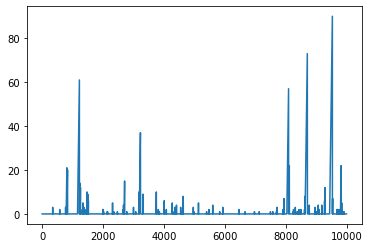

In [46]:
plt.plot(result.asymptotic)

## Dwell bias

In [140]:
from enum import Enum

DwellBias = Enum("DwellBias", "TRUE PARTISAN OTHER NON_CONVERGED")

EPSILON = 0.025  # if true bias is 0.60, consider equal if in the range 0.575 to 0.625. 
START_INDEX = 2000

def find_dwell_bias(non_partisan_mean: np.array) -> DwellBias:
    # all non-partisans have the same bias
    one_mean = non_partisan_mean[0]
    if np.allclose(non_partisan_mean, one_mean, atol=EPSILON):

        # all non partisans have the partisan bias
        if np.isclose(one_mean, PARTISAN_BIAS, atol=EPSILON):
            return DwellBias.PARTISAN

        # all non-partisans have the true bias
        elif np.isclose(one_mean, TRUE_BIAS, atol=EPSILON):
            return DwellBias.TRUE

        else: 
            return DwellBias.OTHER

    # something else...
    return DwellBias.NON_CONVERGED

In [149]:
DwellBiasPeakResult = namedtuple("DwellBiasPeakResult", "time peak non_partisan_mean")

def find_dwell_bias_peaks(result: Result, start_index: int=0) -> dict[DwellBias, DwellBiasPeakResult]:
    asymptotic = result.asymptotic[start_index:]
    non_partisans_mean = result.non_partisans_mean[start_index:]

    # find the indices of each element of asymptotic that is greater than the next element
    # (i.e. the indices of the peaks)
    asymptotic_peak_idxs = np.where(np.diff(asymptotic) < 0)[0]

    for i in asymptotic_peak_idxs: # make sure that code above worked correctly
        assert (asymptotic[i] > 0 and asymptotic[i+1] == 0)

    asymptotic_peaks = [asymptotic[i] for i in asymptotic_peak_idxs]

    dwell_biases = [find_dwell_bias(non_partisans_mean[i]) for i in asymptotic_peak_idxs]

    # list of each bias and the asymptotic learning peaks that correspond to it
    dwell_bias_peaks_by_bias = {bias: [] for bias in DwellBias}

    dwell_bias_peaks = zip(asymptotic_peak_idxs, dwell_biases, asymptotic_peaks)
    for i, bias, peak in dwell_bias_peaks:
        time = i + start_index
        dwell_bias_peaks_by_bias[bias].append(DwellBiasPeakResult(time, peak, non_partisans_mean[i][-1]))
    
    return dict(dwell_bias_peaks_by_bias)

In [150]:
dwell_bias_peaks_by_bias = find_dwell_bias_peaks(result, start_index=START_INDEX)
assert dwell_bias_peaks_by_bias[DwellBias.NON_CONVERGED] == []

In [151]:
dwell_bias_peaks_by_bias[DwellBias.OTHER]

[DwellBiasPeakResult(time=2034, peak=10, non_partisan_mean=0.5477321431736402),
 DwellBiasPeakResult(time=2036, peak=1, non_partisan_mean=0.5472375464402217),
 DwellBiasPeakResult(time=2064, peak=27, non_partisan_mean=0.549106955286359),
 DwellBiasPeakResult(time=2070, peak=5, non_partisan_mean=0.5497221116475226),
 DwellBiasPeakResult(time=2081, peak=6, non_partisan_mean=0.5529389695269108),
 DwellBiasPeakResult(time=2087, peak=5, non_partisan_mean=0.5544560331563824),
 DwellBiasPeakResult(time=2095, peak=1, non_partisan_mean=0.5517374952251957),
 DwellBiasPeakResult(time=2097, peak=1, non_partisan_mean=0.551137941452642),
 DwellBiasPeakResult(time=2105, peak=2, non_partisan_mean=0.5531742706328755),
 DwellBiasPeakResult(time=2116, peak=2, non_partisan_mean=0.5525753368977444),
 DwellBiasPeakResult(time=2119, peak=2, non_partisan_mean=0.5531016562587878),
 DwellBiasPeakResult(time=2156, peak=7, non_partisan_mean=0.5498895393423021),
 DwellBiasPeakResult(time=2162, peak=1, non_partisan

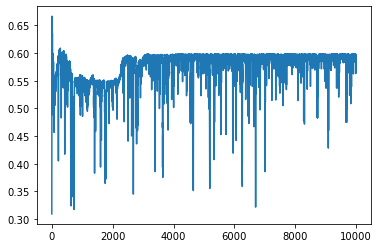

In [130]:
plt.plot([mean[-1] for mean in result.non_partisans_mean])

In [211]:
[result.peak for result in dwell_bias_peaks_by_bias[DwellBias.TRUE]]

[1,
 1,
 1,
 4,
 3,
 1,
 2,
 2,
 1,
 2,
 2,
 3,
 2,
 1,
 3,
 3,
 1,
 1,
 1,
 3,
 3,
 2,
 2,
 2,
 12,
 6,
 2,
 7,
 9,
 6,
 2,
 1,
 1,
 7,
 4,
 8,
 1,
 2,
 1,
 1,
 11,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 8,
 3,
 7,
 4,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 3,
 8,
 10,
 1,
 1,
 1,
 3,
 2,
 1,
 1,
 4,
 5,
 1,
 13,
 2,
 1,
 3,
 1,
 1,
 2,
 9,
 1,
 6,
 1,
 1,
 1,
 2,
 1,
 8,
 1,
 7,
 8,
 1,
 1,
 9,
 6,
 1,
 5,
 1,
 5,
 2,
 2,
 1,
 1,
 5,
 5,
 15,
 2,
 1,
 1,
 5,
 7,
 1,
 11,
 1,
 23,
 3,
 1,
 5,
 3,
 7,
 19,
 14,
 1,
 28,
 1,
 14,
 3,
 15,
 1,
 1,
 1,
 1,
 11,
 6,
 4,
 4,
 1,
 3,
 5,
 1,
 4,
 1,
 1,
 5,
 4,
 14,
 6,
 4,
 4,
 7,
 7,
 3,
 1,
 1,
 11,
 5,
 15,
 3,
 1,
 16,
 3,
 1,
 16,
 4,
 4,
 13,
 7,
 1,
 1,
 4,
 1,
 1,
 9,
 4,
 17,
 10,
 4,
 1,
 3,
 4,
 7,
 7,
 1,
 9,
 1,
 1,
 1,
 11,
 3,
 3,
 3,
 1,
 5,
 42,
 13,
 6,
 1,
 12,
 1,
 12,
 3,
 1,
 4,
 7,
 4,
 1,
 7,
 3,
 16,
 8,
 6,
 3,
 1,
 1,
 1,
 1,
 10,
 5,
 7,
 5,
 9,
 9,
 1,
 4,


In [182]:
big_list_true, big_list_partisan, big_list_other, big_list_nonconverge = [], [], [], []

In [238]:
from cProfile import label


def plot_mean(dwellbias: DwellBias): 
    fracs = [result.partisans for result in results]
    mean_dt_true = np.array([np.mean([db.peak for db in find_dwell_bias_peaks(result)[dwellbias]]) 
                        for result in results])
    np.nan_to_num(mean_dt_true, copy=False)

    plt.plot(fracs, mean_dt_true, label=dwellbias.name)


/Users/buyutong/miniforge3/envs/opinion-dynamics/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/buyutong/miniforge3/envs/opinion-dynamics/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/buyutong/miniforge3/envs/opinion-dynamics/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/buyutong/miniforge3/envs/opinion-dynamics/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/buyutong/miniforge3/envs/opinion-dynamics/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


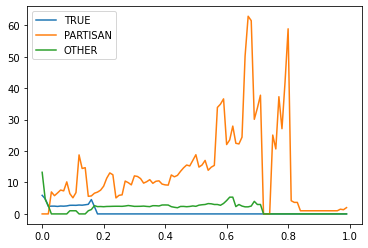

In [239]:
plot_mean(DwellBias.TRUE)
plot_mean(DwellBias.PARTISAN)
plot_mean(DwellBias.OTHER)
plt.legend()
